In [ ]:
# ===============================
# Deep Neural Network using Tensorflow using fit API
# Dataset: Cat and Dogs Recognition
# ===============================
from math import *
import matplotlib.pyplot as plt
import numpy as np
import h5py
from typing import List, Optional, Tuple
from dataclasses import dataclass
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
import tensorflow as tf
from functools import partial
import optuna

/Users/tomcuel/.venvs/global_env/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
def load_data(
    validation_ratio: float = 0.5,
    random_state: int = 42
) -> Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
    """
    Load training and test data from HDF5 files and split test set into validation and final test sets

    Parameters
    validation_ratio : float, optional (default=0.5)
        Fraction of the original test set to use as validation data
    random_state : int, optional (default=42)
        Random seed for reproducibility

    Returns
    X_train : np.ndarray
        Training features
    y_train : np.ndarray
        Training labels
    X_val : np.ndarray
        Validation features
    y_val : np.ndarray
        Validation labels
    X_test : np.ndarray
        Test features
    y_test : np.ndarray
        Test labels
    """
    # Load training data
    with h5py.File("../cat_dog_datasets/trainset.hdf5", "r") as train_dataset:
        X_train = np.array(train_dataset["X_train"][:])
        y_train = np.array(train_dataset["Y_train"][:])

    # Load test data
    with h5py.File("../cat_dog_datasets/testset.hdf5", "r") as test_dataset:
        X_test_full = np.array(test_dataset["X_test"][:])
        y_test_full = np.array(test_dataset["Y_test"][:])

    # Split test data into validation and test sets
    X_val, X_test, y_val, y_test = train_test_split(
        X_test_full,
        y_test_full,
        test_size=validation_ratio,
        random_state=random_state,
        stratify=y_test_full if len(np.unique(y_test_full)) > 1 else None
    )

    return X_train, y_train, X_val, y_val, X_test, y_test

In [ ]:
# Define human-readable label names
label_names = {0: "Cat", 1: "Dog"}

def plot_images(
    X: np.ndarray,
    y: np.ndarray,
    y_pred: Optional[np.ndarray] = None,
    num_images: int = 10,
    img_shape: Tuple[int, int] = (64, 64)
):
    """
    Plot flattened/normalized images with true and predicted labels
    
    Parameters:
    X : np.ndarray
        Flattened images (N, features)
    y : np.ndarray
        One-hot encoded true labels (N, num_classes)
    y_pred : np.ndarray, optional
        One-hot encoded predicted labels (N, num_classes)
    img_shape : tuple
        Original image shape (H, W)

    Returns:
    """
    # Convert one-hot to integer labels if needed
    if y.ndim > 1:
        y_int = np.argmax(y, axis=1)
    else:
        y_int = y

    # Dynamically compute grid size
    n_cols = min(5, num_images)  # max 5 images per row
    n_rows = ceil(num_images / n_cols)

    plt.figure(figsize=(4*n_cols, 4*n_rows))
    
    for i in range(num_images):
        plt.subplot(n_rows, n_cols, i+1)
        
        # Reshape flattened image back to original shape
        img = X[i].reshape(img_shape)
        plt.imshow(img, cmap='gray')
        
        # Title with True / Pred labels
        title = f"True: {label_names[y_int[i]]}"
        if y_pred is not None:
            title += f"\nPred: {label_names[y_pred[i]]}"
            
            # Optional: color title green/red for correct/incorrect
            color = 'green' if y_int[i] == y_pred[i] else 'red'
            plt.title(title, color=color, fontsize=10)
        else:
            plt.title(title, fontsize=10)
        
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

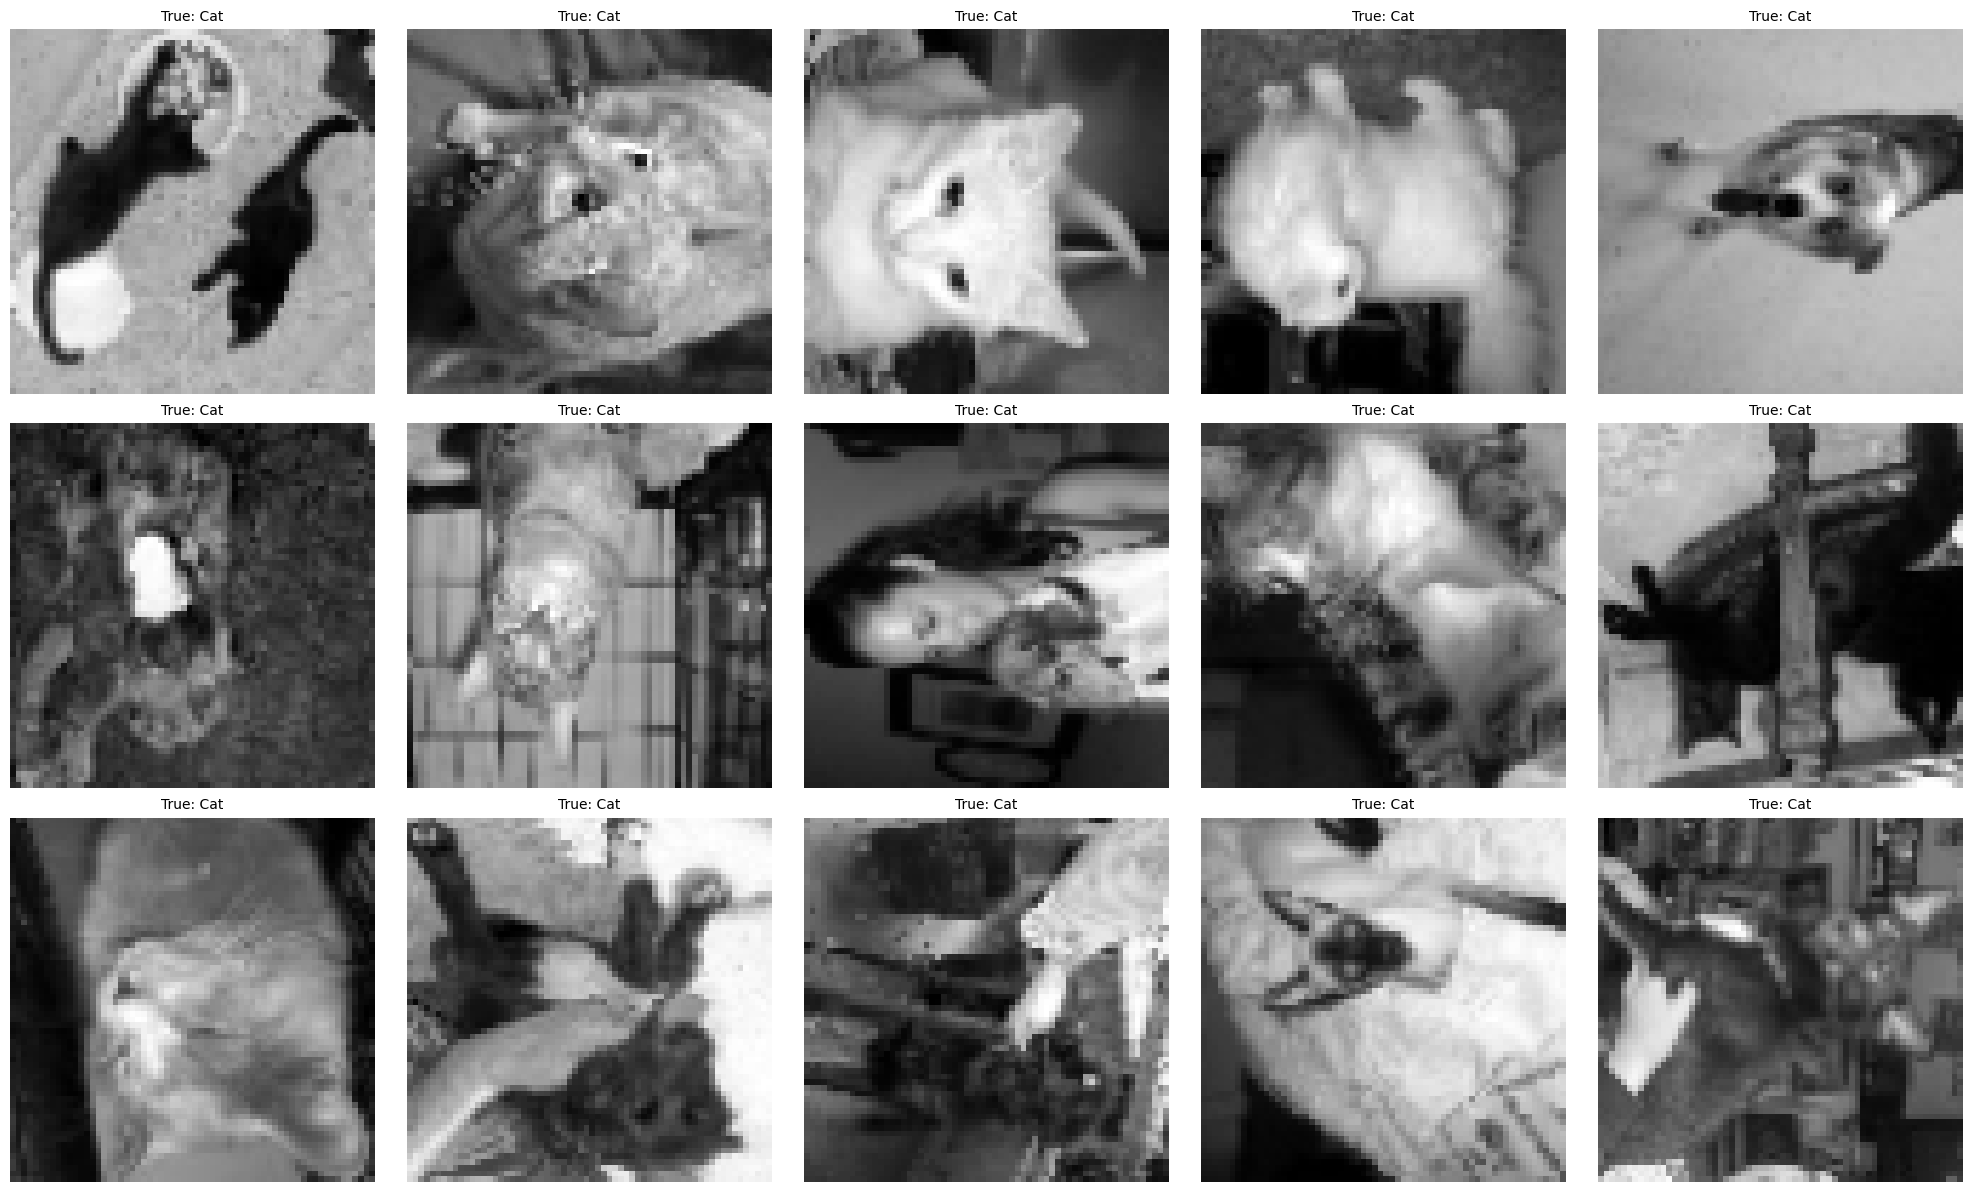

Preprocessing data...


/Users/tomcuel/.venvs/global_env/lib/python3.13/site-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/tomcuel/.venvs/global_env/lib/python3.13/site-packages/sklearn/preprocessing/_label.py:129: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/Users/tomcuel/.venvs/global_env/lib/python3.13/site-packages/sklearn/preprocessing/_label.py:129: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


In [ ]:
# =======================================
# 1. Load and Preprocess Data
# =======================================
X_train, y_train, X_val, y_val, X_test, y_test = load_data()
img_shape = X_train.shape[1:]

# Data Augmentation Function
def augment_image(
    image: tf.Tensor
) -> tf.Tensor:
    """
    Apply data augmentation to a single image tensor

    Parameters: 
    image : tf.Tensor
        Input image tensor  
        
    Returns:
    tf.Tensor
        Augmented image tensor
    """
    # Random horizontal flip
    image = tf.image.random_flip_left_right(image)
    
    # Small rotations
    image = tf.image.rot90(image, k=tf.random.uniform(shape=[], minval=0, maxval=4, dtype=tf.int32))
    
    # Random brightness / contrast
    image = tf.image.random_brightness(image, max_delta=0.2)
    image = tf.image.random_contrast(image, lower=0.8, upper=1.2)
    
    # Small zoom (crop + resize)
    crop_scale = tf.random.uniform([], 0.9, 1.0)
    crop_size = tf.cast(crop_scale * tf.cast(tf.shape(image)[:2], tf.float32), tf.int32)
    image = tf.image.random_crop(image, size=tf.concat([crop_size, tf.shape(image)[-1:]], axis=0))
    image = tf.image.resize(image, img_shape[:2])
    
    return image

# Apply augmentation to the whole dataset
X_train_aug = []
for i in range(X_train.shape[0]):
    img = tf.convert_to_tensor(X_train[i], dtype=tf.float32)
    if len(img.shape) == 2:  # Add channel dimension if missing
        img = tf.expand_dims(img, axis=-1)
    img_aug = augment_image(img)
    X_train_aug.append(img_aug.numpy())

X_train = np.array(X_train_aug)
X_train = X_train.reshape(X_train.shape[0], -1)
X_val = X_val.reshape(X_val.shape[0], -1)
X_test = X_test.reshape(X_test.shape[0], -1)
plot_images(X_train, y_train, num_images=15)

# Normalize
print("Preprocessing data...")
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

# One-hot encode labels
encoder = LabelEncoder()
y_train = encoder.fit_transform(y_train.reshape(-1, 1))
y_val = encoder.transform(y_val.reshape(-1, 1))
y_test = encoder.transform(y_test.reshape(-1, 1))

input_dim = int(X_train.shape[1])
output_dim = int(len(np.unique(y_train)))

[I 2025-10-30 17:29:08,183] A new study created in memory with name: no-name-0cb190ba-673e-43ef-9edd-c7fc22a1021a


Epoch 1/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 0.9550 - sparse_categorical_accuracy: 0.5012 - val_loss: 1.8909 - val_sparse_categorical_accuracy: 0.5100
Epoch 2/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.6838 - sparse_categorical_accuracy: 0.6324 - val_loss: 1.2283 - val_sparse_categorical_accuracy: 0.4800
Epoch 3/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.6296 - sparse_categorical_accuracy: 0.6656 - val_loss: 1.0415 - val_sparse_categorical_accuracy: 0.4800
Epoch 4/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.5622 - sparse_categorical_accuracy: 0.7056 - val_loss: 1.1593 - val_sparse_categorical_accuracy: 0.4600
Epoch 5/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.4991 - sparse_categorical_accuracy: 0.7656 - val_loss: 1.1492 - val_sparse_categorical_accuracy: 0.5100
Epoch 6/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.4502 - sparse_categorical_accuracy: 0.7751 - val_loss: 1.1140 - val_sparse_categorical_accuracy: 0.4900
Epoch 7/50

2025-10-30 17:29:14.066503: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
[I 2025-10-30 17:29:14,068] Trial 0 finished with value: 0.9349042177200317 and parameters: {'n_layers': 2, 'n_units_l0': 355, 'n_units_l1': 408, 'activation': 'leaky_relu', 'dropout_l0': 0.12247106055342907, 'dropout_l1': 0.2537484469933723, 'weight_decay': 8.040219244903356e-06, 'lr': 0.0013523431891264695, 'batch_size': 64, 'step_size': 5.675166496688372, 'gamma': 0.7732414034931135, 'stopping_patience': 14}. Best is trial 0 with value: 0.9349042177200317.


Epoch 1/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 0.9269 - sparse_categorical_accuracy: 0.5117 - val_loss: 0.8515 - val_sparse_categorical_accuracy: 0.4500
Epoch 2/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.7257 - sparse_categorical_accuracy: 0.5392 - val_loss: 0.9651 - val_sparse_categorical_accuracy: 0.4000
Epoch 3/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.7231 - sparse_categorical_accuracy: 0.5627 - val_loss: 0.8703 - val_sparse_categorical_accuracy: 0.4500
Epoch 4/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.7108 - sparse_categorical_accuracy: 0.5691 - val_loss: 0.7912 - val_sparse_categorical_accuracy: 0.4600
Epoch 5/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.7017 - sparse_categorical_accuracy: 0.5730 - val_loss: 0.7449 - val_sparse_categorical_accuracy: 0.5200
Epoch 6/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.6341 - sparse_categorical_accuracy: 0.6338 - val_loss: 0.8123 - val_sparse_categorical_accuracy: 0.4300
Epoch 7/50
16/1

2025-10-30 17:29:17.813607: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
[I 2025-10-30 17:29:17,814] Trial 1 finished with value: 0.7520309686660767 and parameters: {'n_layers': 3, 'n_units_l0': 256, 'n_units_l1': 202, 'n_units_l2': 196, 'activation': 'tanh', 'dropout_l0': 0.22190773041289627, 'dropout_l1': 0.33946116036507723, 'dropout_l2': 0.1768481932308019, 'weight_decay': 2.157254612357427e-05, 'lr': 0.002428726254505924, 'batch_size': 64, 'step_size': 18.26721142629486, 'gamma': 0.9103754190785807, 'stopping_patience': 9}. Best is trial 1 with value: 0.7520309686660767.


Epoch 1/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 1.1045 - sparse_categorical_accuracy: 0.5269 - val_loss: 0.7968 - val_sparse_categorical_accuracy: 0.4800
Epoch 2/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.7282 - sparse_categorical_accuracy: 0.5419 - val_loss: 0.8963 - val_sparse_categorical_accuracy: 0.4200
Epoch 3/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.7266 - sparse_categorical_accuracy: 0.5491 - val_loss: 0.8481 - val_sparse_categorical_accuracy: 0.4300
Epoch 4/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.7026 - sparse_categorical_accuracy: 0.5875 - val_loss: 0.7333 - val_sparse_categorical_accuracy: 0.4900
Epoch 5/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.6651 - sparse_categorical_accuracy: 0.6075 - val_loss: 0.8167 - val_sparse_categorical_accuracy: 0.4400
Epoch 6/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.6609 - sparse_categorical_accuracy: 0.6089 - val_loss: 0.7974 - val_sparse_categorical_accuracy: 0.5000
Epoch 7/50
16/1

[I 2025-10-30 17:29:21,210] Trial 2 finished with value: 0.7369269728660583 and parameters: {'n_layers': 2, 'n_units_l0': 304, 'n_units_l1': 75, 'activation': 'tanh', 'dropout_l0': 0.2541560216263401, 'dropout_l1': 0.2553436433009772, 'weight_decay': 1.2075697366601469e-05, 'lr': 0.003901675996258903, 'batch_size': 64, 'step_size': 11.47191871508528, 'gamma': 0.8161095783534641, 'stopping_patience': 11}. Best is trial 2 with value: 0.7369269728660583.


Epoch 1/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 0.8444 - sparse_categorical_accuracy: 0.4987 - val_loss: 0.9045 - val_sparse_categorical_accuracy: 0.4900
Epoch 2/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.8079 - sparse_categorical_accuracy: 0.5117 - val_loss: 0.8311 - val_sparse_categorical_accuracy: 0.4800
Epoch 3/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.7948 - sparse_categorical_accuracy: 0.5277 - val_loss: 0.7768 - val_sparse_categorical_accuracy: 0.4800
Epoch 4/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.7613 - sparse_categorical_accuracy: 0.5087 - val_loss: 0.7657 - val_sparse_categorical_accuracy: 0.4400
Epoch 5/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.7598 - sparse_categorical_accuracy: 0.5506 - val_loss: 0.8123 - val_sparse_categorical_accuracy: 0.4200
Epoch 6/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.7347 - sparse_categorical_accuracy: 0.5471 - val_loss: 0.7864 - val_sparse_categorical_accuracy: 0.4200
Epoch 7/50
16/1

2025-10-30 17:29:24.581317: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
[I 2025-10-30 17:29:24,582] Trial 3 finished with value: 0.7832502126693726 and parameters: {'n_layers': 4, 'n_units_l0': 73, 'n_units_l1': 208, 'n_units_l2': 81, 'n_units_l3': 85, 'activation': 'relu', 'dropout_l0': 0.3897855353411539, 'dropout_l1': 0.2262311541666982, 'dropout_l2': 0.23384725756710473, 'dropout_l3': 0.1417811596960017, 'weight_decay': 4.548945202759742e-05, 'lr': 0.00026666431701671866, 'batch_size': 64, 'step_size': 13.855723997875119, 'gamma': 0.7324536344393443, 'stopping_patience': 5}. Best is trial 2 with value: 0.7369269728660583.


Epoch 1/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 1.0075 - sparse_categorical_accuracy: 0.4923 - val_loss: 1.0882 - val_sparse_categorical_accuracy: 0.5000
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.7365 - sparse_categorical_accuracy: 0.6230 - val_loss: 1.0630 - val_sparse_categorical_accuracy: 0.4700
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.6830 - sparse_categorical_accuracy: 0.6346 - val_loss: 0.9637 - val_sparse_categorical_accuracy: 0.4800
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.6306 - sparse_categorical_accuracy: 0.6743 - val_loss: 1.0263 - val_sparse_categorical_accuracy: 0.4200
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.5900 - sparse_categorical_accuracy: 0.7018 - val_loss: 0.8540 - val_sparse_categorical_accuracy: 0.5000
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.5158 - sparse_categorical_accuracy: 0.7286 - val_loss: 0.8535 - val_sparse_categorical_accuracy: 0.5000
Epoch 7/50


[I 2025-10-30 17:29:29,896] Trial 4 finished with value: 0.8198251724243164 and parameters: {'n_layers': 2, 'n_units_l0': 444, 'n_units_l1': 295, 'activation': 'relu', 'dropout_l0': 0.257015869716267, 'dropout_l1': 0.3976854403983771, 'weight_decay': 1.3684954317939938e-06, 'lr': 0.00021770006026084366, 'batch_size': 32, 'step_size': 18.46451581732697, 'gamma': 0.7883176275022176, 'stopping_patience': 5}. Best is trial 2 with value: 0.7369269728660583.


Epoch 1/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.8901 - sparse_categorical_accuracy: 0.5183 - val_loss: 1.1111 - val_sparse_categorical_accuracy: 0.5200
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.8123 - sparse_categorical_accuracy: 0.5442 - val_loss: 0.9866 - val_sparse_categorical_accuracy: 0.5400
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.8456 - sparse_categorical_accuracy: 0.5441 - val_loss: 0.9229 - val_sparse_categorical_accuracy: 0.5100
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.7727 - sparse_categorical_accuracy: 0.5892 - val_loss: 0.8825 - val_sparse_categorical_accuracy: 0.5000
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.7433 - sparse_categorical_accuracy: 0.5738 - val_loss: 0.7880 - val_sparse_categorical_accuracy: 0.5300
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.7109 - sparse_categorical_accuracy: 0.5638 - val_loss: 0.8347 - val_sparse_categorical_accuracy: 0.4700
Epoch 7/50
32/32

[I 2025-10-30 17:29:34,294] Trial 5 finished with value: 0.7531702518463135 and parameters: {'n_layers': 3, 'n_units_l0': 64, 'n_units_l1': 192, 'n_units_l2': 186, 'activation': 'leaky_relu', 'dropout_l0': 0.27290391538724457, 'dropout_l1': 0.23851348539632727, 'dropout_l2': 0.3596691800275281, 'weight_decay': 1.4351386798818234e-05, 'lr': 0.0011052652341304102, 'batch_size': 32, 'step_size': 7.516727872714467, 'gamma': 0.7225010413663865, 'stopping_patience': 7}. Best is trial 2 with value: 0.7369269728660583.


Epoch 1/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - loss: 0.9227 - sparse_categorical_accuracy: 0.4996 - val_loss: 1.4934 - val_sparse_categorical_accuracy: 0.5000
Epoch 2/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.7984 - sparse_categorical_accuracy: 0.5443 - val_loss: 1.0418 - val_sparse_categorical_accuracy: 0.5400
Epoch 3/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.7473 - sparse_categorical_accuracy: 0.5654 - val_loss: 0.8620 - val_sparse_categorical_accuracy: 0.5300
Epoch 4/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.7068 - sparse_categorical_accuracy: 0.6036 - val_loss: 0.7931 - val_sparse_categorical_accuracy: 0.5000
Epoch 5/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.6770 - sparse_categorical_accuracy: 0.6480 - val_loss: 0.8207 - val_sparse_categorical_accuracy: 0.4700
Epoch 6/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.6287 - sparse_categorical_accuracy: 0.6551 - val_loss: 0.8165 - val_sparse_categorical_accuracy: 0.5000
Epoch 7/50

[I 2025-10-30 17:29:40,761] Trial 6 finished with value: 0.7970663905143738 and parameters: {'n_layers': 4, 'n_units_l0': 392, 'n_units_l1': 255, 'n_units_l2': 185, 'n_units_l3': 94, 'activation': 'relu', 'dropout_l0': 0.15108084377432443, 'dropout_l1': 0.22606649897463124, 'dropout_l2': 0.15463584101477706, 'dropout_l3': 0.20168642679894958, 'weight_decay': 0.00012381414706518664, 'lr': 0.00011464910231085687, 'batch_size': 64, 'step_size': 6.908734382510856, 'gamma': 0.8026464247798338, 'stopping_patience': 15}. Best is trial 2 with value: 0.7369269728660583.


Epoch 1/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - loss: 0.8646 - sparse_categorical_accuracy: 0.5187 - val_loss: 0.8070 - val_sparse_categorical_accuracy: 0.4600
Epoch 2/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.6834 - sparse_categorical_accuracy: 0.5979 - val_loss: 0.7653 - val_sparse_categorical_accuracy: 0.4600
Epoch 3/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.6576 - sparse_categorical_accuracy: 0.6265 - val_loss: 0.7491 - val_sparse_categorical_accuracy: 0.4900
Epoch 4/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.6714 - sparse_categorical_accuracy: 0.6016 - val_loss: 0.7728 - val_sparse_categorical_accuracy: 0.4700
Epoch 5/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.6469 - sparse_categorical_accuracy: 0.6488 - val_loss: 0.7823 - val_sparse_categorical_accuracy: 0.5100
Epoch 6/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.6059 - sparse_categorical_accuracy: 0.6578 - val_loss: 0.8197 - val_sparse_categorical_accuracy: 0.5000
Epoch 7/50
8/8 ━━━━━━━

2025-10-30 17:29:44.848602: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
[I 2025-10-30 17:29:44,850] Trial 7 finished with value: 0.7491360306739807 and parameters: {'n_layers': 3, 'n_units_l0': 419, 'n_units_l1': 129, 'n_units_l2': 223, 'activation': 'tanh', 'dropout_l0': 0.19269685667620295, 'dropout_l1': 0.37484054782442333, 'dropout_l2': 0.17773863042547258, 'weight_decay': 2.026826517828204e-06, 'lr': 0.0004435243547614427, 'batch_size': 128, 'step_size': 9.844573234668339, 'gamma': 0.9262239013301085, 'stopping_patience': 12}. Best is trial 2 with value: 0.7369269728660583.


Epoch 1/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.8823 - sparse_categorical_accuracy: 0.5122 - val_loss: 2.5136 - val_sparse_categorical_accuracy: 0.4800
Epoch 2/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.6892 - sparse_categorical_accuracy: 0.6083 - val_loss: 1.3574 - val_sparse_categorical_accuracy: 0.4800
Epoch 3/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.6516 - sparse_categorical_accuracy: 0.6040 - val_loss: 0.9903 - val_sparse_categorical_accuracy: 0.4900
Epoch 4/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.6395 - sparse_categorical_accuracy: 0.6202 - val_loss: 1.0492 - val_sparse_categorical_accuracy: 0.4500
Epoch 5/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.5993 - sparse_categorical_accuracy: 0.6740 - val_loss: 0.8247 - val_sparse_categorical_accuracy: 0.4700
Epoch 6/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.5562 - sparse_categorical_accuracy: 0.7251 - val_loss: 0.8394 - val_sparse_categorical_accuracy: 0.4900
Epoch 7/50
16/1

[I 2025-10-30 17:29:48,068] Trial 8 finished with value: 0.8515663146972656 and parameters: {'n_layers': 2, 'n_units_l0': 165, 'n_units_l1': 76, 'activation': 'relu', 'dropout_l0': 0.2674003725643193, 'dropout_l1': 0.1919822552988841, 'weight_decay': 0.00017930080433288233, 'lr': 0.0027981070833439556, 'batch_size': 64, 'step_size': 11.599349720019688, 'gamma': 0.7256633375592093, 'stopping_patience': 11}. Best is trial 2 with value: 0.7369269728660583.


Epoch 1/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.9404 - sparse_categorical_accuracy: 0.5030 - val_loss: 1.2324 - val_sparse_categorical_accuracy: 0.5000
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.6652 - sparse_categorical_accuracy: 0.6291 - val_loss: 0.9354 - val_sparse_categorical_accuracy: 0.4900
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.6793 - sparse_categorical_accuracy: 0.6312 - val_loss: 0.8598 - val_sparse_categorical_accuracy: 0.5400
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.6127 - sparse_categorical_accuracy: 0.6526 - val_loss: 0.9452 - val_sparse_categorical_accuracy: 0.5100
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.5721 - sparse_categorical_accuracy: 0.7014 - val_loss: 0.8288 - val_sparse_categorical_accuracy: 0.5200
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.5245 - sparse_categorical_accuracy: 0.7244 - val_loss: 0.8205 - val_sparse_categorical_accuracy: 0.5200
Epoch 7/50
32/

[I 2025-10-30 17:29:55,014] Trial 9 finished with value: 0.7921875715255737 and parameters: {'n_layers': 3, 'n_units_l0': 250, 'n_units_l1': 417, 'n_units_l2': 87, 'activation': 'leaky_relu', 'dropout_l0': 0.14772867291156266, 'dropout_l1': 0.23054564846418363, 'dropout_l2': 0.21630905120561073, 'weight_decay': 4.987043594146013e-06, 'lr': 0.0003831682418047499, 'batch_size': 32, 'step_size': 15.63246675620333, 'gamma': 0.8690086573976032, 'stopping_patience': 11}. Best is trial 2 with value: 0.7369269728660583.


Epoch 1/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - loss: 2.1061 - sparse_categorical_accuracy: 0.5045 - val_loss: 1.3722 - val_sparse_categorical_accuracy: 0.5100
Epoch 2/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.9349 - sparse_categorical_accuracy: 0.5528 - val_loss: 0.8644 - val_sparse_categorical_accuracy: 0.5400
Epoch 3/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.7703 - sparse_categorical_accuracy: 0.5538 - val_loss: 0.7826 - val_sparse_categorical_accuracy: 0.5600
Epoch 4/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.7674 - sparse_categorical_accuracy: 0.5077 - val_loss: 0.7790 - val_sparse_categorical_accuracy: 0.5300
Epoch 5/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.7162 - sparse_categorical_accuracy: 0.5235 - val_loss: 0.7910 - val_sparse_categorical_accuracy: 0.4300
Epoch 6/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.6579 - sparse_categorical_accuracy: 0.6134 - val_loss: 0.8030 - val_sparse_categorical_accuracy: 0.4300
Epoch 7/50
8/8 ━━━━━━━

[I 2025-10-30 17:29:59,546] Trial 10 finished with value: 0.7511096000671387 and parameters: {'n_layers': 2, 'n_units_l0': 329, 'n_units_l1': 510, 'activation': 'tanh', 'dropout_l0': 0.345294086061644, 'dropout_l1': 0.11047363758191747, 'weight_decay': 0.0008706339991817563, 'lr': 0.004980630303435875, 'batch_size': 128, 'step_size': 9.819644035003748, 'gamma': 0.9713244975285754, 'stopping_patience': 9}. Best is trial 2 with value: 0.7369269728660583.


Epoch 1/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - loss: 0.8351 - sparse_categorical_accuracy: 0.4993 - val_loss: 0.7507 - val_sparse_categorical_accuracy: 0.4800
Epoch 2/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.7192 - sparse_categorical_accuracy: 0.5545 - val_loss: 0.7013 - val_sparse_categorical_accuracy: 0.5300
Epoch 3/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.6766 - sparse_categorical_accuracy: 0.5737 - val_loss: 0.7412 - val_sparse_categorical_accuracy: 0.4500
Epoch 4/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.6489 - sparse_categorical_accuracy: 0.6305 - val_loss: 0.7135 - val_sparse_categorical_accuracy: 0.5300
Epoch 5/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.6411 - sparse_categorical_accuracy: 0.6230 - val_loss: 0.7517 - val_sparse_categorical_accuracy: 0.5100
Epoch 6/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.6217 - sparse_categorical_accuracy: 0.6628 - val_loss: 0.7564 - val_sparse_categorical_accuracy: 0.4900
Epoch 7/50
8/8 ━━━━━━━

[I 2025-10-30 17:30:03,503] Trial 11 finished with value: 0.7013129591941833 and parameters: {'n_layers': 3, 'n_units_l0': 501, 'n_units_l1': 70, 'n_units_l2': 256, 'activation': 'tanh', 'dropout_l0': 0.1949553726817993, 'dropout_l1': 0.3183693339918378, 'dropout_l2': 0.1035514927853731, 'weight_decay': 1.1080203340035909e-06, 'lr': 0.0005780607274703614, 'batch_size': 128, 'step_size': 10.301922228908658, 'gamma': 0.8618042197563613, 'stopping_patience': 13}. Best is trial 11 with value: 0.7013129591941833.


Epoch 1/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step - loss: 0.8917 - sparse_categorical_accuracy: 0.5139 - val_loss: 0.7644 - val_sparse_categorical_accuracy: 0.4100
Epoch 2/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.8559 - sparse_categorical_accuracy: 0.5189 - val_loss: 0.7785 - val_sparse_categorical_accuracy: 0.4100
Epoch 3/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.7958 - sparse_categorical_accuracy: 0.5480 - val_loss: 0.7633 - val_sparse_categorical_accuracy: 0.4400
Epoch 4/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.7942 - sparse_categorical_accuracy: 0.5229 - val_loss: 0.8101 - val_sparse_categorical_accuracy: 0.4700
Epoch 5/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.7869 - sparse_categorical_accuracy: 0.5441 - val_loss: 0.7902 - val_sparse_categorical_accuracy: 0.4500
Epoch 6/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.7308 - sparse_categorical_accuracy: 0.5756 - val_loss: 0.8568 - val_sparse_categorical_accuracy: 0.4100
Epoch 7/50
8/8 ━━━━━━━

[I 2025-10-30 17:30:08,539] Trial 12 finished with value: 0.7632721662521362 and parameters: {'n_layers': 4, 'n_units_l0': 508, 'n_units_l1': 74, 'n_units_l2': 255, 'n_units_l3': 123, 'activation': 'tanh', 'dropout_l0': 0.3172005535536894, 'dropout_l1': 0.31633394615471216, 'dropout_l2': 0.33591613957344724, 'dropout_l3': 0.3977961917616093, 'weight_decay': 3.5184428940997644e-06, 'lr': 0.0008436862030144657, 'batch_size': 128, 'step_size': 12.409188288017951, 'gamma': 0.8563345716802713, 'stopping_patience': 13}. Best is trial 11 with value: 0.7013129591941833.


Epoch 1/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - loss: 1.0648 - sparse_categorical_accuracy: 0.5146 - val_loss: 0.9353 - val_sparse_categorical_accuracy: 0.5100
Epoch 2/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.7692 - sparse_categorical_accuracy: 0.5944 - val_loss: 0.7622 - val_sparse_categorical_accuracy: 0.5100
Epoch 3/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.6945 - sparse_categorical_accuracy: 0.6000 - val_loss: 0.8552 - val_sparse_categorical_accuracy: 0.5000
Epoch 4/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.6674 - sparse_categorical_accuracy: 0.6155 - val_loss: 0.7871 - val_sparse_categorical_accuracy: 0.4900
Epoch 5/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.5928 - sparse_categorical_accuracy: 0.6708 - val_loss: 0.7849 - val_sparse_categorical_accuracy: 0.5000
Epoch 6/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.6287 - sparse_categorical_accuracy: 0.6572 - val_loss: 0.8362 - val_sparse_categorical_accuracy: 0.4900
Epoch 7/50
8/8 ━━━━━━━

[I 2025-10-30 17:30:12,251] Trial 13 finished with value: 0.7621771097183228 and parameters: {'n_layers': 2, 'n_units_l0': 497, 'n_units_l1': 126, 'activation': 'tanh', 'dropout_l0': 0.2015616012687694, 'dropout_l1': 0.29200100132134943, 'weight_decay': 1.2271821243495813e-06, 'lr': 0.0005847562633371218, 'batch_size': 128, 'step_size': 9.954079367432685, 'gamma': 0.8281798753885748, 'stopping_patience': 13}. Best is trial 11 with value: 0.7013129591941833.


Epoch 1/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.8527 - sparse_categorical_accuracy: 0.4982 - val_loss: 0.8799 - val_sparse_categorical_accuracy: 0.4600
Epoch 2/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.7177 - sparse_categorical_accuracy: 0.5413 - val_loss: 0.8140 - val_sparse_categorical_accuracy: 0.4400
Epoch 3/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.7021 - sparse_categorical_accuracy: 0.5769 - val_loss: 0.7647 - val_sparse_categorical_accuracy: 0.4300
Epoch 4/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.6758 - sparse_categorical_accuracy: 0.5848 - val_loss: 0.8397 - val_sparse_categorical_accuracy: 0.4500
Epoch 5/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.6676 - sparse_categorical_accuracy: 0.5923 - val_loss: 0.7856 - val_sparse_categorical_accuracy: 0.4200
Epoch 6/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.6308 - sparse_categorical_accuracy: 0.6540 - val_loss: 0.7978 - val_sparse_categorical_accuracy: 0.4500
Epoch 7/50
8/8 ━━━━━━━━━━━━

[I 2025-10-30 17:30:15,352] Trial 14 finished with value: 0.7516376972198486 and parameters: {'n_layers': 3, 'n_units_l0': 176, 'n_units_l1': 126, 'n_units_l2': 134, 'activation': 'tanh', 'dropout_l0': 0.30974515468851505, 'dropout_l1': 0.1626547393696568, 'dropout_l2': 0.10755330933214094, 'weight_decay': 6.195429649812374e-05, 'lr': 0.0016573274513714594, 'batch_size': 128, 'step_size': 14.458443967047337, 'gamma': 0.8796881883130221, 'stopping_patience': 10}. Best is trial 11 with value: 0.7013129591941833.


Epoch 1/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 1.1994 - sparse_categorical_accuracy: 0.5006 - val_loss: 0.9465 - val_sparse_categorical_accuracy: 0.4300
Epoch 2/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.7892 - sparse_categorical_accuracy: 0.5243 - val_loss: 0.9267 - val_sparse_categorical_accuracy: 0.4200
Epoch 3/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.7184 - sparse_categorical_accuracy: 0.5829 - val_loss: 0.8098 - val_sparse_categorical_accuracy: 0.4200
Epoch 4/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.6913 - sparse_categorical_accuracy: 0.5888 - val_loss: 0.8083 - val_sparse_categorical_accuracy: 0.4600
Epoch 5/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.6443 - sparse_categorical_accuracy: 0.6029 - val_loss: 0.8869 - val_sparse_categorical_accuracy: 0.4700
Epoch 6/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.6354 - sparse_categorical_accuracy: 0.6513 - val_loss: 0.7870 - val_sparse_categorical_accuracy: 0.5100
Epoch 7/50

2025-10-30 17:30:20.689051: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
[I 2025-10-30 17:30:20,691] Trial 15 finished with value: 0.7803561687469482 and parameters: {'n_layers': 2, 'n_units_l0': 309, 'n_units_l1': 302, 'activation': 'tanh', 'dropout_l0': 0.22595644356818312, 'dropout_l1': 0.2835390394295606, 'weight_decay': 8.090154553627502e-06, 'lr': 0.0035256853099106976, 'batch_size': 64, 'step_size': 8.561491116443605, 'gamma': 0.8277064960262542, 'stopping_patience': 15}. Best is trial 11 with value: 0.7013129591941833.


Epoch 1/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 0.9004 - sparse_categorical_accuracy: 0.5290 - val_loss: 0.7947 - val_sparse_categorical_accuracy: 0.4800
Epoch 2/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.8542 - sparse_categorical_accuracy: 0.4981 - val_loss: 0.7693 - val_sparse_categorical_accuracy: 0.4800
Epoch 3/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.8160 - sparse_categorical_accuracy: 0.5253 - val_loss: 0.7621 - val_sparse_categorical_accuracy: 0.4700
Epoch 4/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.7924 - sparse_categorical_accuracy: 0.5528 - val_loss: 0.7715 - val_sparse_categorical_accuracy: 0.5000
Epoch 5/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.7635 - sparse_categorical_accuracy: 0.5590 - val_loss: 0.7687 - val_sparse_categorical_accuracy: 0.5000
Epoch 6/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.7489 - sparse_categorical_accuracy: 0.5742 - val_loss: 0.7621 - val_sparse_categorical_accuracy: 0.4900
Epoch 7/50
8/8 ━━━━━━━━━

[I 2025-10-30 17:30:24,949] Trial 16 finished with value: 0.7408204078674316 and parameters: {'n_layers': 4, 'n_units_l0': 194, 'n_units_l1': 73, 'n_units_l2': 138, 'n_units_l3': 67, 'activation': 'tanh', 'dropout_l0': 0.17725422909720964, 'dropout_l1': 0.35112018116823446, 'dropout_l2': 0.3005242508001597, 'dropout_l3': 0.34454626892641127, 'weight_decay': 0.0005713745505887859, 'lr': 0.0006883152122642566, 'batch_size': 128, 'step_size': 11.73567359579847, 'gamma': 0.7718777321060608, 'stopping_patience': 12}. Best is trial 11 with value: 0.7013129591941833.


Epoch 1/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - loss: 0.9591 - sparse_categorical_accuracy: 0.5213 - val_loss: 0.7501 - val_sparse_categorical_accuracy: 0.5100
Epoch 2/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.8734 - sparse_categorical_accuracy: 0.5258 - val_loss: 0.7494 - val_sparse_categorical_accuracy: 0.5200
Epoch 3/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.8223 - sparse_categorical_accuracy: 0.5615 - val_loss: 0.7503 - val_sparse_categorical_accuracy: 0.4900
Epoch 4/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.7200 - sparse_categorical_accuracy: 0.6155 - val_loss: 0.7404 - val_sparse_categorical_accuracy: 0.5500
Epoch 5/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.7290 - sparse_categorical_accuracy: 0.5936 - val_loss: 0.7592 - val_sparse_categorical_accuracy: 0.5600
Epoch 6/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.7120 - sparse_categorical_accuracy: 0.6124 - val_loss: 0.7597 - val_sparse_categorical_accuracy: 0.5300
Epoch 7/50
8/8 ━━━━━━━

[I 2025-10-30 17:30:28,612] Trial 17 finished with value: 0.7403991222381592 and parameters: {'n_layers': 3, 'n_units_l0': 444, 'n_units_l1': 148, 'n_units_l2': 252, 'activation': 'tanh', 'dropout_l0': 0.29061718669379305, 'dropout_l1': 0.2777513904864274, 'dropout_l2': 0.39981728901443825, 'weight_decay': 2.8249970694510865e-06, 'lr': 0.00012209967597993273, 'batch_size': 128, 'step_size': 5.022721024706041, 'gamma': 0.920164338112773, 'stopping_patience': 8}. Best is trial 11 with value: 0.7013129591941833.


Epoch 1/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 1.2708 - sparse_categorical_accuracy: 0.5174 - val_loss: 0.8108 - val_sparse_categorical_accuracy: 0.4500
Epoch 2/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.7924 - sparse_categorical_accuracy: 0.5276 - val_loss: 0.7818 - val_sparse_categorical_accuracy: 0.5000
Epoch 3/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.7320 - sparse_categorical_accuracy: 0.5581 - val_loss: 0.9640 - val_sparse_categorical_accuracy: 0.4300
Epoch 4/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.6717 - sparse_categorical_accuracy: 0.6434 - val_loss: 0.9468 - val_sparse_categorical_accuracy: 0.4200
Epoch 5/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.7359 - sparse_categorical_accuracy: 0.6049 - val_loss: 0.9836 - val_sparse_categorical_accuracy: 0.4400
Epoch 6/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.6309 - sparse_categorical_accuracy: 0.6702 - val_loss: 0.9269 - val_sparse_categorical_accuracy: 0.4600
Epoch 7/50
16/

[I 2025-10-30 17:30:32,404] Trial 18 finished with value: 0.7783216238021851 and parameters: {'n_layers': 2, 'n_units_l0': 366, 'n_units_l1': 353, 'activation': 'tanh', 'dropout_l0': 0.2329660859372374, 'dropout_l1': 0.31826342842623606, 'weight_decay': 2.1701763251306806e-05, 'lr': 0.0017444670384467267, 'batch_size': 64, 'step_size': 16.634683291302288, 'gamma': 0.7522433653293091, 'stopping_patience': 13}. Best is trial 11 with value: 0.7013129591941833.


Epoch 1/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.8035 - sparse_categorical_accuracy: 0.5038 - val_loss: 0.8330 - val_sparse_categorical_accuracy: 0.5400
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6544 - sparse_categorical_accuracy: 0.6198 - val_loss: 0.8580 - val_sparse_categorical_accuracy: 0.5000
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6192 - sparse_categorical_accuracy: 0.6780 - val_loss: 0.7925 - val_sparse_categorical_accuracy: 0.5100
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5618 - sparse_categorical_accuracy: 0.7083 - val_loss: 0.8615 - val_sparse_categorical_accuracy: 0.4600
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5459 - sparse_categorical_accuracy: 0.7159 - val_loss: 0.8777 - val_sparse_categorical_accuracy: 0.5100
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4842 - sparse_categorical_accuracy: 0.7538 - val_loss: 0.9296 - val_sparse_categorical_accuracy: 0.4300
Epoch 7/50
32/32

[I 2025-10-30 17:30:36,272] Trial 19 finished with value: 0.7281875610351562 and parameters: {'n_layers': 3, 'n_units_l0': 131, 'n_units_l1': 170, 'n_units_l2': 221, 'activation': 'leaky_relu', 'dropout_l0': 0.11658823389587561, 'dropout_l1': 0.1532891971065815, 'dropout_l2': 0.10326376670387345, 'weight_decay': 9.012362698118785e-06, 'lr': 0.0002343623067072163, 'batch_size': 32, 'step_size': 10.796817326294375, 'gamma': 0.9676450481130505, 'stopping_patience': 11}. Best is trial 11 with value: 0.7013129591941833.


Best trial:
  Value: 0.7013
  Params:
    n_layers: 3
    n_units_l0: 501
    n_units_l1: 70
    n_units_l2: 256
    activation: tanh
    dropout_l0: 0.1949553726817993
    dropout_l1: 0.3183693339918378
    dropout_l2: 0.1035514927853731
    weight_decay: 1.1080203340035909e-06
    lr: 0.0005780607274703614
    batch_size: 128
    step_size: 10.301922228908658
    gamma: 0.8618042197563613
    stopping_patience: 13
Epoch 1/150
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - loss: 0.9472 - sparse_categorical_accuracy: 0.4899 - val_loss: 0.7099 - val_sparse_categorical_accuracy: 0.5000
Epoch 2/150
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.7033 - sparse_categorical_accuracy: 0.5835 - val_loss: 0.7395 - val_sparse_categorical_accuracy: 0.4900
Epoch 3/150
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.7033 - sparse_categorical_accuracy: 0.5530 - val_loss: 0.7323 - val_sparse_categorical_accuracy: 0.4400
Epoch 4/150
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.6837 - sparse_categorical_ac

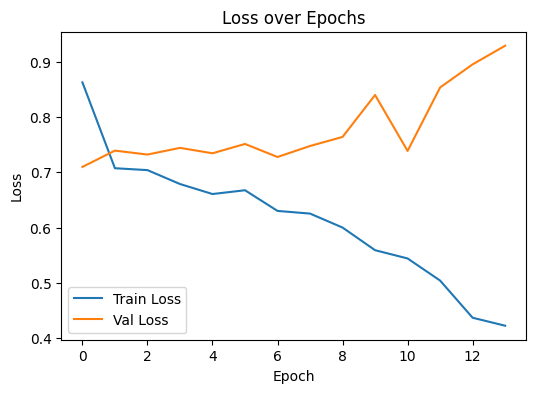

Test Accuracy: 50.00%


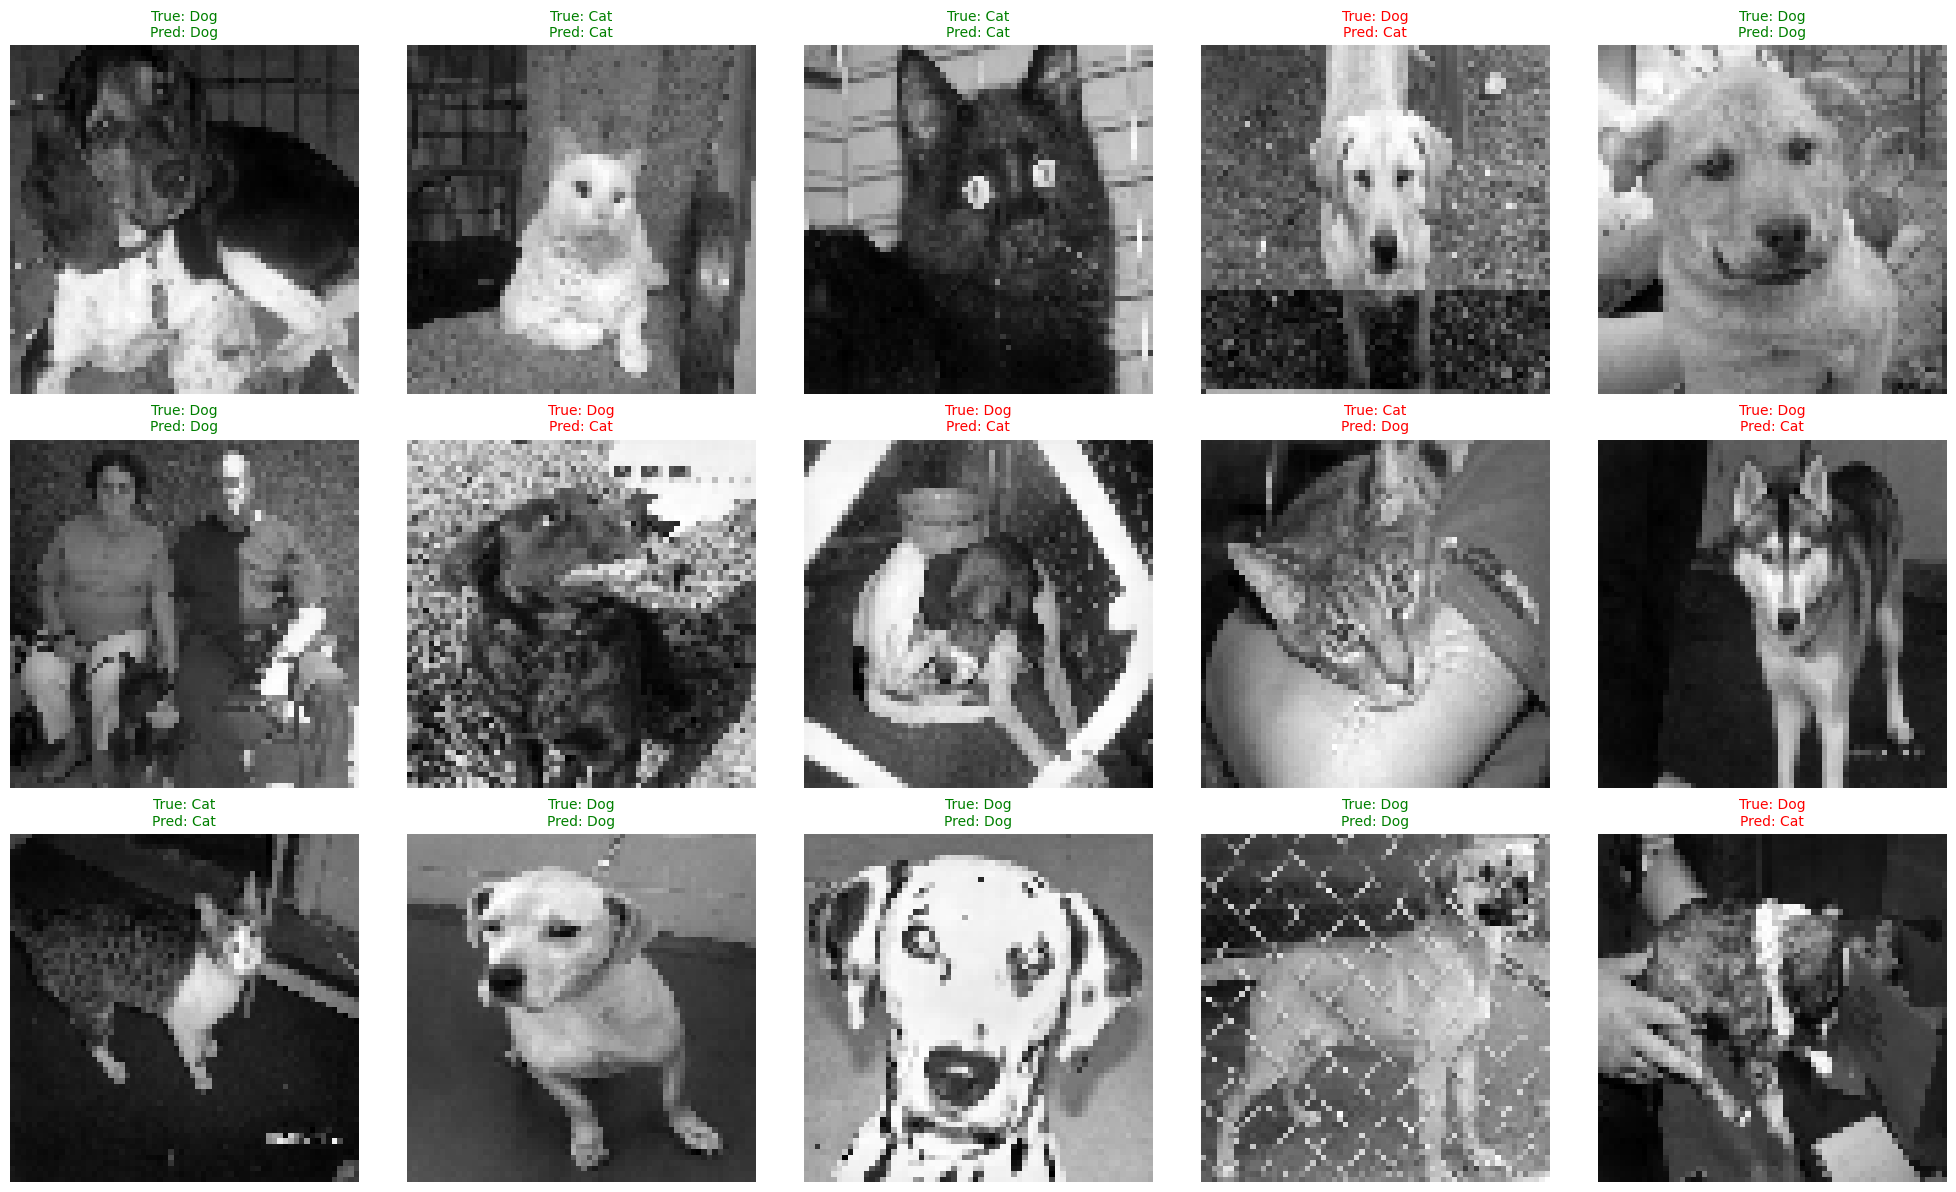

In [ ]:
RNG_SEED = 42
np.random.seed(RNG_SEED)
tf.random.set_seed(RNG_SEED)


# =======================================
# 2. Tensor Creation
# =======================================
def df_to_tf_dataset(
    X, 
    y, 
    batch_size=64, 
    shuffle=True
) -> tf.data.Dataset:
    """
    Create a TensorFlow Dataset from features and labels

    Parameters:
    X : np.ndarray
        Feature array
    y : np.ndarray
        Label array
    batch_size : int, optional (default=64)
        Batch size for the dataset
    shuffle : bool, optional (default=True)
        Whether to shuffle the dataset

    Returns:
    tf.data.Dataset
        TensorFlow dataset object
    """
    ds = tf.data.Dataset.from_tensor_slices((tf.convert_to_tensor(X, dtype=tf.float32), tf.convert_to_tensor(y, dtype=tf.int32)))
    if shuffle:
        ds = ds.shuffle(buffer_size=len(X))
    return ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)


# =======================================
# 3. Activation function
# =======================================
_ACTIVATION_MAP = {
    "relu": lambda: tf.keras.layers.ReLU(),
    "sigmoid": lambda: tf.keras.layers.Activation("sigmoid"),
    "tanh": lambda: tf.keras.layers.Activation("tanh"),
    "leaky_relu": lambda: tf.keras.layers.LeakyReLU(negative_slope=0.01),
    "gelu": lambda: tf.keras.layers.Activation(tf.nn.gelu),
    "elu": lambda: tf.keras.layers.ELU(),
    "softmax_logit": None  # handled separately for logits
}


# =======================================
# 4. Dataclass for hyperparameters
# =======================================
@dataclass
class TrainConfig:
    hidden_layers: list[int] = None
    activations: Optional[List[float]] = None
    dropout_rates: Optional[List[float]] = None
    loss_function: str = "cross_entropy"
    lr: float = 1e-3
    batch_size: int = 64
    epochs: int = 100
    weight_decay: float = 1e-5
    step_size: int = 20
    gamma: float = 0.5
    early_stopping: bool = True
    patience: int = 10
    clip_grad_norm: Optional[float] = 1.0
    use_amp: bool = True  # automatic mixed precision


# =======================================
# 5. Model Definition
# =======================================
class DeepNN(tf.keras.Model):
    def __init__(
        self,
        input_dim: int,
        hidden_layers: List[int],
        output_dim: int,
        activations: Optional[List[str]] = None,
        dropout_rates: Optional[List[float]] = None,
        use_batchnorm: bool = True
    ):
        """
        Deep Neural Network with configurable architecture

        Parameters:
        input_dim : int
            Dimension of input features
        hidden_layers : List[int]
            List containing the number of units in each hidden layer
        output_dim : int
            Number of output classes
        activations : List[str], optional
            List of activation function names for each hidden layer
        dropout_rates : List[float], optional
            List of dropout rates for each hidden layer
        use_batchnorm : bool, optional
            Whether to use batch normalization after each hidden layer

        Returns:
        """
        super().__init__()
        self.layers_list = []
        n_hidden = len(hidden_layers)

        if activations is None:
            activations = ["relu"] * len(hidden_layers)
        if dropout_rates is None:
            dropout_rates = [0.0] * len(hidden_layers)
        assert len(activations) == n_hidden
        assert len(dropout_rates) == n_hidden

        for idx, h in enumerate(hidden_layers):
            act_name = activations[idx]
            act_ctor = _ACTIVATION_MAP.get(act_name)
            # Choose weight initializer based on activation
            if act_name in ("relu", "leaky_relu"):
                kernel_init = tf.keras.initializers.HeNormal()
            else:
                kernel_init = tf.keras.initializers.GlorotNormal()  # Xavier
            # Dense layer
            self.layers_list.append(tf.keras.layers.Dense(h, kernel_initializer=kernel_init, bias_initializer="zeros"))
            # Optional batch normalization
            if use_batchnorm:
                self.layers_list.append(tf.keras.layers.BatchNormalization())
            # Activation
            if act_ctor is not None:
                self.layers_list.append(act_ctor() if callable(act_ctor) else act_ctor)
            # Dropout
            if dropout_rates[idx] and dropout_rates[idx] > 0:
                self.layers_list.append(tf.keras.layers.Dropout(dropout_rates[idx]))

        # Final linear layer → logits (no activation)
        self.layers_list.append(
            tf.keras.layers.Dense(output_dim, kernel_initializer=tf.keras.initializers.GlorotNormal(), bias_initializer="zeros")
        )

    def call(
        self: tf.keras.Model,
        inputs: tf.Tensor,
        training: bool = False
    ) -> tf.Tensor:
        """
        Forward pass through the network

        Parameters:
        inputs : tf.Tensor
            Input tensor
        training : bool, optional
            Whether in training mode (for dropout, batchnorm)

        Returns:
        tf.Tensor
            Output logits tensor
        """
        x = inputs
        for layer in self.layers_list:
            if isinstance(layer, tf.keras.layers.Dropout):
                x = layer(x, training=training)
            else:
                x = layer(x)
        return x


# =======================================
# 6. Training Function
# =======================================
def train_model(
    X_train: np.ndarray,
    y_train: np.ndarray, 
    X_val: np.ndarray,
    y_val: np.ndarray,
    input_dim: int,
    output_dim: int,
    config: TrainConfig,
    plot_loss: bool = False
) -> Tuple[tf.keras.Model, tf.keras.callbacks.History]:
    """
    Train the Deep Neural Network model

    Parameters:
    X_train : np.ndarray
        Training features
    y_train : np.ndarray
        Training labels
    X_val : np.ndarray
        Validation features
    y_val : np.ndarray
        Validation labels
    input_dim : int
        Dimension of input features
    output_dim : int
        Number of output classes
    config : TrainConfig
        Training configuration parameters
    plot_loss : bool, optional
        Whether to plot training and validation loss curves

    Returns:
    model : tf.keras.Model
        Trained model
    history : tf.keras.callbacks.History
        Training history object
    """
    # Dataloaders
    train_dataset = df_to_tf_dataset(X_train, y_train, batch_size=config.batch_size)
    val_dataset = df_to_tf_dataset(X_val, y_val, batch_size=config.batch_size, shuffle=False)

    # AMP policy
    if config.use_amp:
        tf.keras.mixed_precision.set_global_policy("mixed_float16")

    # Model creation
    model = DeepNN(input_dim, config.hidden_layers, output_dim, config.activations, config.dropout_rates)

    # Learning rate scheduler
    lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=config.lr,
        decay_steps=config.step_size * len(train_dataset),
        decay_rate=config.gamma,
        staircase=True,
    )

    # Optimizer
    optimizer = tf.keras.optimizers.AdamW(learning_rate=lr_schedule, weight_decay=config.weight_decay)

    # Compile model
    model.compile(
        optimizer=optimizer,
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=[tf.keras.metrics.SparseCategoricalAccuracy()],
    )

    # Callbacks (Early stopping + checkpoint)
    callbacks = []
    if config.early_stopping:
        callbacks.append(
            tf.keras.callbacks.EarlyStopping(
                monitor="val_loss", patience=config.patience,
                restore_best_weights=True, verbose=1,
            )
        )

    callbacks.append(
        tf.keras.callbacks.ModelCheckpoint(
            filepath="best_model.weights.h5",
            monitor="val_loss",
            save_best_only=True, save_weights_only=True,
        )
    )

    # Train the model
    history = model.fit(
        train_dataset, validation_data=val_dataset,
        epochs=config.epochs,
        verbose=1,callbacks=callbacks,
    )

    # Plot losses
    if plot_loss:
        plt.figure(figsize=(6, 4))
        plt.plot(history.history["loss"], label="Train Loss")
        plt.plot(history.history["val_loss"], label="Val Loss")
        plt.legend()
        plt.title("Loss over Epochs")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.show()

    return model, history


# =======================================
# 7. Prediction & Evaluation
# =======================================
def predict_tf(
    model: tf.keras.Model,
    X: np.ndarray,
    y: np.ndarray, 
    batch_size: int = 64
) -> Tuple[np.ndarray, np.ndarray]: 
    """
    Predict classes and probabilities using the trained model

    Parameters:
    model : tf.keras.Model
        Trained model
    X : np.ndarray
        Input features
    y : np.ndarray
        True labels
    batch_size : int, optional
        Batch size for prediction  

    Returns:
    np.ndarray
        Predicted class labels
    np.ndarray
        Predicted class probabilities
    """
    ds = df_to_tf_dataset(X, y, batch_size=batch_size, shuffle=False) 
    probs_list = [] 
    for X_batch, _ in ds:
        logits = model(X_batch, training=False) 
        probs = tf.nn.softmax(logits) 
        probs_list.append(probs) 
    probs = tf.concat(probs_list, axis=0) 
    preds = tf.argmax(probs, axis=1).numpy()
    return preds, probs.numpy()

def accuracy_score(
    y_true: np.ndarray,
    y_pred: np.ndarray
) -> float:
    """
    Compute accuracy score between true and predicted labels

    Parameters:
    y_true : np.ndarray
        True labels
    y_pred : np.ndarray
        Predicted labels

    Returns:
    float
        Accuracy percentage
    """
    return np.mean(y_true == y_pred) * 100


# =======================================
# 8. Hyperparameter Optimization with Optuna
# =======================================
def objective(
    trial: optuna.trial.Trial,
    loss_function: str = "cross_entropy",
    epochs: int = 40
) -> float:
    """
    Objective function for Optuna hyperparameter optimization

    Parameters:
    trial : optuna.trial.Trial
        Optuna trial object
    loss_function : str, optional
        Loss function to use
    epochs : int, optional
        Number of training epochs
    Returns:
    float
        Validation loss to minimize
    """
    # Number of hidden layers (shallower works better on raw pixels)
    n_layers = trial.suggest_int("n_layers", 2, 4) 

    # Decreasing width pattern (funnel architecture)
    hidden_layers = []
    for i in range(n_layers):
        max_units = max(64, input_dim // (2 ** (i + 2)))
        hidden_layers.append(trial.suggest_int(f"n_units_l{i}", 64, min(max_units, 512)))
        
    # Common activation (keeps optimization stable)
    activation = trial.suggest_categorical("activation", ["relu", "leaky_relu", "tanh"])
    activations = [activation] * n_layers
    # possible_activations = ["relu", "tanh", "leaky_relu"]
    # activations = [trial.suggest_categorical(f"activation_l{i}", possible_activations) for i in range(n_layers)]

    # Regularization
    dropout_rates = [trial.suggest_float(f"dropout_l{i}", 0.1, 0.4) for i in range(n_layers)]
    weight_decay = trial.suggest_float("weight_decay", 1e-6, 1e-3, log=True)

    # Optimizer params
    lr = trial.suggest_float("lr", 1e-4, 5e-3, log=True)
    batch_size = trial.suggest_categorical("batch_size", [32, 64, 128])
    step_size = trial.suggest_float("step_size", 5, 20)
    gamma = trial.suggest_float("gamma", 0.7, 0.99, log=True)

    # Early stopping
    stopping_patience = trial.suggest_int("stopping_patience", 5, 15)

    config = TrainConfig(
        hidden_layers=hidden_layers, 
        activations=activations, 
        dropout_rates=dropout_rates, 
        loss_function=loss_function, 
        lr=lr, 
        batch_size=batch_size, 
        epochs=epochs, 
        weight_decay=weight_decay, 
        step_size=step_size, 
        gamma=gamma,
        early_stopping=True, 
        patience=stopping_patience, 
        use_amp=True
    )

    model, _ = train_model(
        X_train, y_train, 
        X_test, y_test,
        input_dim, output_dim,
        config,
        plot_loss=False
    )

    # Validation loss
    val_dataset = df_to_tf_dataset(X_test, y_test, batch_size=config.batch_size)
    loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
    val_loss_metric = tf.keras.metrics.Mean()
    for X_batch, y_batch in val_dataset:
        logits = model(X_batch, training=False)
        val_loss_metric.update_state(loss_fn(y_batch, logits))

    return val_loss_metric.result().numpy()


# Run Optuna study
loss_function = "cross_entropy"
epochs = 50
obj = partial(objective, loss_function=loss_function, epochs=epochs)
study = optuna.create_study(direction="minimize", pruner=optuna.pruners.MedianPruner())
study.optimize(obj, n_trials=20)

# Best result summary
print("Best trial:")
trial = study.best_trial
print(f"  Value: {trial.value:.4f}")
print("  Params:")
for key, value in trial.params.items():
    print(f"    {key}: {value}")


# =======================================
# 9. Retrain Best Model on Train + Val and Evaluate on Test
# =======================================
best_params = trial.params
n_layers = best_params["n_layers"]
hidden_layers = [best_params[f"n_units_l{i}"] for i in range(n_layers)]
lr = best_params["lr"]
batch_size = best_params["batch_size"]
dropout_rates = [best_params[f"dropout_l{i}"] for i in range(n_layers)]
weight_decay = best_params["weight_decay"]
stopping_patience = best_params["stopping_patience"]
# activations = [best_params[f"activation_l{i}"] for i in range(n_layers)]
activations = [best_params["activation"]] * n_layers
step_size = best_params["step_size"]
gamma = best_params["gamma"]

config = TrainConfig(
    hidden_layers=hidden_layers, 
    activations=activations, 
    dropout_rates=dropout_rates, 
    loss_function=loss_function, 
    lr=lr, 
    batch_size=batch_size, 
    epochs=epochs*3, 
    weight_decay=weight_decay, 
    step_size=step_size, 
    gamma=gamma,
    early_stopping=True, 
    patience=stopping_patience, 
    use_amp=True
    )

# Retrain final model
best_model, history = train_model(
    X_train, y_train,
    X_test, y_test,
    input_dim, output_dim,
    config,
    plot_loss=True
)

# Evaluate on test set
y_pred_test, _ = predict_tf(best_model, X_test, y_test, batch_size=batch_size)
test_accuracy = accuracy_score(y_test, y_pred_test)
print(f"Test Accuracy: {test_accuracy:.2f}%")
plot_images(X_test, y_test, y_pred_test, num_images=15)